In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, regularizers
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping

# Dataset Anime

In [2]:
df_anime = pd.read_csv('/content/Anime_2023.csv')
df_anime.head(5)

,anime_id,Name,Genres,Other name,Score,Type
0,1,Cowboy Bebop,"Action, Award Winning, Sci-Fi",カウボーイビバップ,8.75,TV
1,5,Cowboy Bebop: Tengoku no Tobira,"Action, Sci-Fi",カウボーイビバップ 天国の扉,8.38,Movie
2,6,Trigun,"Action, Adventure, Sci-Fi",トライガン,8.22,TV
3,7,Witch Hunter Robin,"Action, Drama, Mystery, Supernatural",Witch Hunter ROBIN (ウイッチハンターロビン),7.25,TV
4,8,Bouken Ou Beet,"Adventure, Fantasy, Supernatural",冒険王ビィト,6.94,TV


## Data Preparation & Preprocessing

In [3]:
df_anime.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19976 entries, 0 to 19975
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   anime_id    19976 non-null  int64 
 1   Name        19976 non-null  object
 2   Genres      19976 non-null  object
 3   Other name  19976 non-null  object
 4   Score       19976 non-null  object
 5   Type        19976 non-null  object
dtypes: int64(1), object(5)
memory usage: 936.5+ KB


**Tidak ada nilai NULL**

In [4]:
df_anime['Score'].unique()

array(['8.75', '8.38', '8.22', '7.25', '6.94', '7.92', '8.0', '7.55',
       '8.16', '8.87', '7.99', '8.69', '7.86', '6.39', '7.89', '7.38',
       '7.76', '7.29', '7.91', '7.48', '8.35', '7.46', '8.55', '8.56',
       '8.27', '8.71', '8.29', '6.95', '7.32', '6.27', '7.26', '7.11',
       '7.06', '6.51', '5.86', '7.03', '7.4', '7.62', '7.17', '6.72',
       '6.56', '7.41', '7.33', '6.31', '7.61', '8.03', '7.93', '7.64',
       '7.97', '8.01', '7.96', '6.76', '7.24', '7.9', '6.68', '7.66',
       '6.62', '6.77', '7.69', '7.74', '7.34', '7.75', '7.18', '7.57',
       '7.79', '7.42', '7.28', '7.16', '7.44', '7.49', '6.4', '7.19',
       '6.79', '7.58', '6.97', '4.82', '7.37', '6.93', '6.78', '6.52',
       '8.11', '7.94', '6.82', '6.44', '6.86', '6.92', '6.74', '6.15',
       '7.39', '8.08', '8.41', '8.31', '8.18', '8.25', '6.1', '6.81',
       '7.07', '7.59', '6.71', '7.1', '7.27', '8.02', '6.57', '6.28',
       '7.3', '6.55', '8.67', '7.36', '8.54', '6.32', '7.2', '6.88',
       '6.59',

In [5]:
columns = ['anime_id', 'Name', 'Genres', 'Other name', 'Score', 'Type']

for i in columns:
  jumlah_unknown = df_anime[i].value_counts().get('UNKNOWN', 0)
  print(f"Jumlah {i} yang tidak diketahui => ", jumlah_unknown, "\n\n")

Jumlah anime_id yang tidak diketahui =>  0 


Jumlah Name yang tidak diketahui =>  0 


Jumlah Genres yang tidak diketahui =>  0 


Jumlah Other name yang tidak diketahui =>  93 


Jumlah Score yang tidak diketahui =>  6037 


Jumlah Type yang tidak diketahui =>  59 




Karena dataset ini akan digunakan untuk sistem rekomendasi dengan teknik **Content Based Filtering**, sehingga fitur `Score` tidak terlalu berpengaruh karena sistem rekomendasi ini berdasarkan `Genres`. Namun karena jumlah UNKNOWN sebanyak 30% data, sehingga saya mengambil pilihan untuk tidak *drop* datanya melainkan menggantinya menjadi 0 dengan asumsi tidak ada *user* yang memberikan penilaian pada *anime* tersebut

In [6]:
df_anime['Score'] = df_anime['Score'].apply(lambda x: 0 if x == 'UNKNOWN' else x)

jumlah_unknown = df_anime['Score'].value_counts().get('UNKNOWN', 0)
print("Jumlah score yang tidak diketahui => ", jumlah_unknown)

Jumlah score yang tidak diketahui =>  0


In [7]:
df_anime['Score'] = df_anime['Score'].astype(float)
df_anime.describe().applymap(lambda x: f"{x:0.2f}")

,anime_id,Score
count,19976.00,19976.00
mean,27093.50,4.50
std,18251.45,3.06
min,1.00,0.00
25%,7750.75,0.00
50%,31014.50,5.93
75%,43301.50,6.81
max,55733.00,9.10


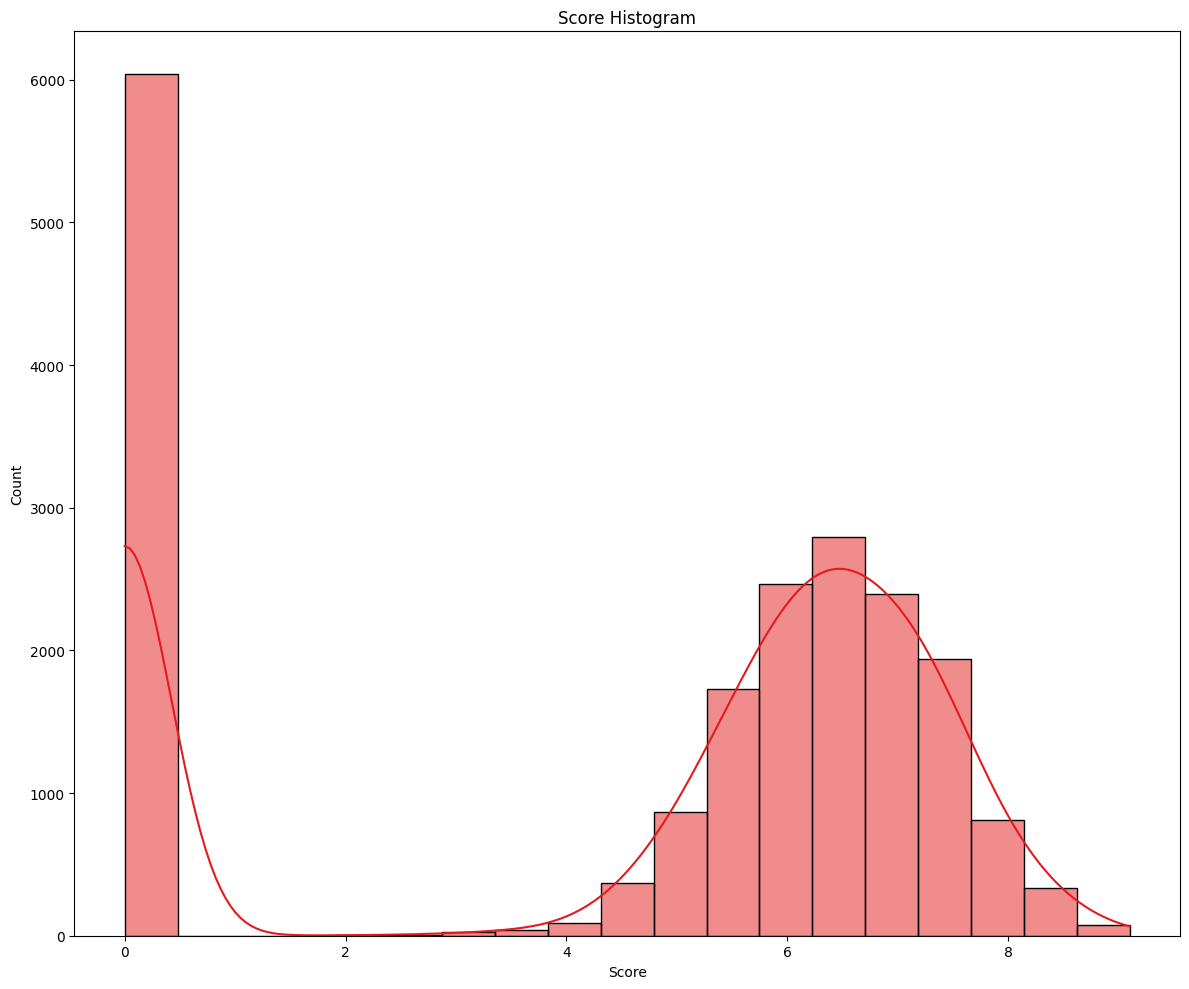

In [8]:
# Histogram untuk fitur Score
col_box = ['Score']
color_palette = sns.color_palette("Set1", len(col_box))
plt.figure(figsize=(12, 10))

sns.histplot(data=df_anime, x='Score', color=color_palette[0], kde=True)
plt.xlabel('Score')
plt.title('Score Histogram')

plt.tight_layout()
plt.savefig('Score_Histogram.png')
plt.show()

Meskipun fitur `Other name` dan `Type` juga memiliki nilai UNKNOWN dengan persentase yang lebih sedikit dibanding fitur `Score`, saya tetap tidak melakukan *drop* data dikarenakan akan mempengaruhi sistem rekomendasi yang dibuat.

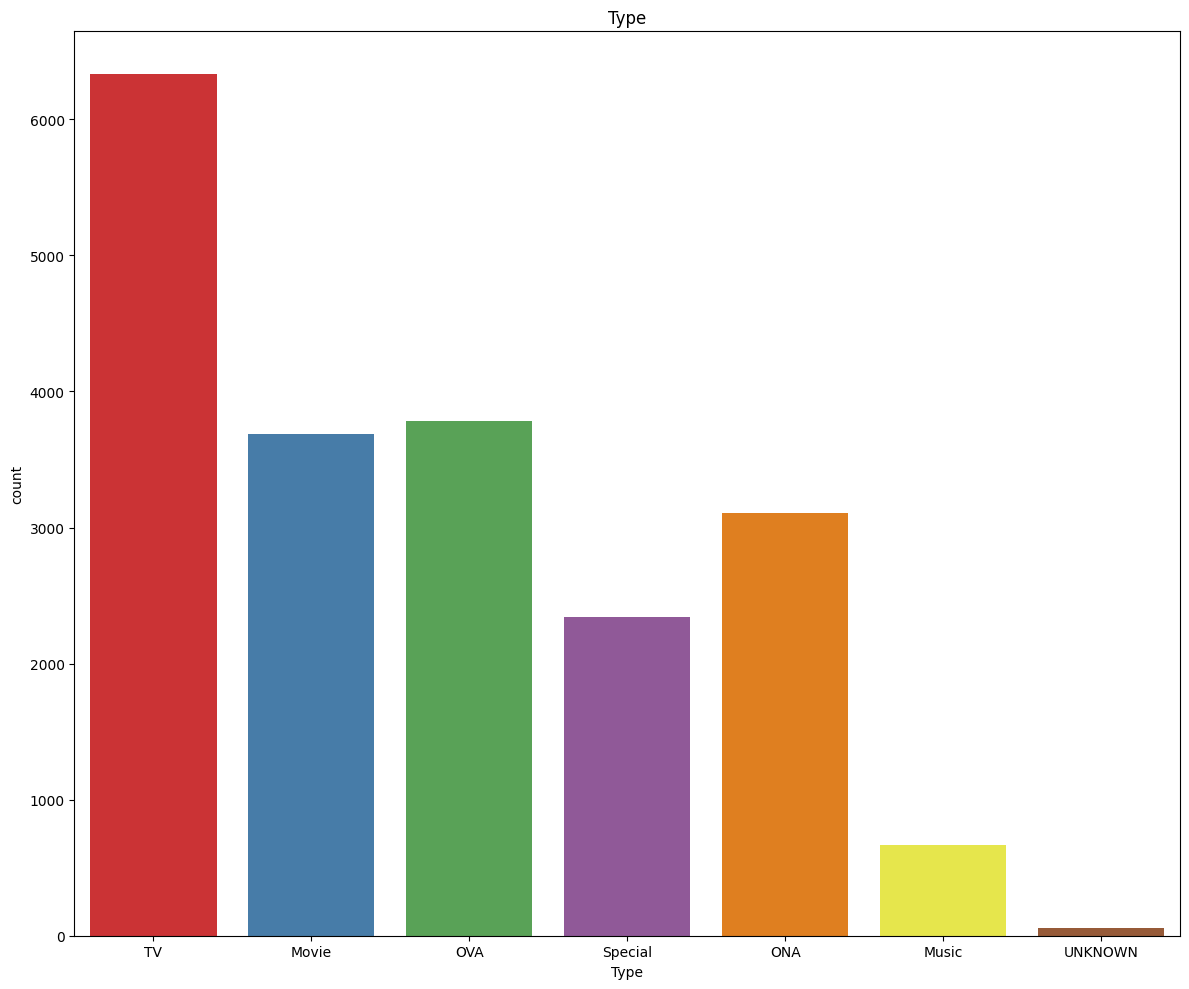

In [9]:
# Barplot untuk fitur Type
plt.figure(figsize=(12, 10))
sns.countplot(data=df_anime, x='Type', hue='Type', palette='Set1')
plt.title('Type')

plt.savefig('Type_Barplot.png')
plt.tight_layout()
plt.show()

Untuk dapat memproses fitur `Genres`, saya ingin melakukan **One Hot Encoding** pada tiap genre yang ada. Namun karena hal tersebut akan menyebabkan ukuran file membesar dan terdapat keterbatasan komputasi sehingga saya akan hanya akan mengambil fitur `anime_id` dan `Name`

In [10]:
df_anime_ohe = df_anime[['anime_id', 'Name']]
genre_ohe = df_anime['Genres'].str.get_dummies(sep=', ')

df_anime_ohe = pd.concat([df_anime_ohe, genre_ohe], axis=1)

In [11]:
pd.set_option('display.max_columns', None)
df_anime_ohe.head(5)

,anime_id,Name,Action,Adventure,Avant Garde,Award Winning,Boys Love,Comedy,Drama,Ecchi,Erotica,Fantasy,Girls Love,Gourmet,Hentai,Horror,Mystery,Romance,Sci-Fi,Slice of Life,Sports,Supernatural,Suspense
0,1,Cowboy Bebop,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
1,5,Cowboy Bebop: Tengoku no Tobira,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
2,6,Trigun,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
3,7,Witch Hunter Robin,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0
4,8,Bouken Ou Beet,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0


In [12]:
df_anime_ohe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19976 entries, 0 to 19975
Data columns (total 23 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   anime_id       19976 non-null  int64 
 1   Name           19976 non-null  object
 2   Action         19976 non-null  int64 
 3   Adventure      19976 non-null  int64 
 4   Avant Garde    19976 non-null  int64 
 5   Award Winning  19976 non-null  int64 
 6   Boys Love      19976 non-null  int64 
 7   Comedy         19976 non-null  int64 
 8   Drama          19976 non-null  int64 
 9   Ecchi          19976 non-null  int64 
 10  Erotica        19976 non-null  int64 
 11  Fantasy        19976 non-null  int64 
 12  Girls Love     19976 non-null  int64 
 13  Gourmet        19976 non-null  int64 
 14  Hentai         19976 non-null  int64 
 15  Horror         19976 non-null  int64 
 16  Mystery        19976 non-null  int64 
 17  Romance        19976 non-null  int64 
 18  Sci-Fi         19976 non-n

## Cosine Similiarity dan Model Sistem Rekomendasi (Content Based Filtering)

In [13]:
cosine_sim = cosine_similarity(genre_ohe)
cs_df_anime = pd.DataFrame(cosine_sim, index=df_anime_ohe['Name'], columns=df_anime_ohe['Name'])
print('Shape:', cs_df_anime.shape)

Shape: (19976, 19976)


In [14]:
pd.set_option('display.max_columns', 10)
cs_df_anime.head(10)

Name,Cowboy Bebop,Cowboy Bebop: Tengoku no Tobira,Trigun,Witch Hunter Robin,Bouken Ou Beet,...,Thailand,Energy,Wu Nao Monu,Bu Xing Si: Yuan Qi,Di Yi Xulie
Name,,,,,,,,,,,
Cowboy Bebop,1.000000,0.816497,0.666667,0.288675,0.000000,...,0.0,0.0,0.000000,0.333333,0.577350
Cowboy Bebop: Tengoku no Tobira,0.816497,1.000000,0.816497,0.353553,0.000000,...,0.0,0.0,0.000000,0.408248,0.707107
Trigun,0.666667,0.816497,1.000000,0.288675,0.333333,...,0.0,0.0,0.000000,0.666667,0.866025
Witch Hunter Robin,0.288675,0.353553,0.288675,1.000000,0.288675,...,0.0,0.0,0.000000,0.288675,0.250000
Bouken Ou Beet,0.000000,0.000000,0.333333,0.288675,1.000000,...,0.0,0.0,0.333333,0.666667,0.577350
Eyeshield 21,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.000000,0.000000,0.000000
Hachimitsu to Clover,0.000000,0.000000,0.000000,0.288675,0.000000,...,0.0,0.0,0.333333,0.000000,0.000000
Hungry Heart: Wild Striker,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.666667,0.000000,0.000000
Initial D Fourth Stage,0.408248,0.500000,0.408248,0.707107,0.000000,...,0.0,0.0,0.000000,0.408248,0.353553


In [15]:
def anime_recommendations(judul_anime, similarity_data=cs_df_anime, items=df_anime[['Name', 'Genres']], k=5):
    index = similarity_data.loc[:,judul_anime].to_numpy().argpartition(
        range(-1, -k, -1))

    closest = similarity_data.columns[index[-1:-(k+2):-1]]
    closest = closest.drop(judul_anime, errors='ignore')

    return pd.DataFrame(closest).merge(items).head(k)

Sebagai percobaan, saya akan mencari rekomendasi *anime* yang mirip dengan [Re:Zero kara Hajimeru Isekai Seikatsu](https://myanimelist.net/anime/31240/Re_Zero_kara_Hajimeru_Isekai_Seikatsu?q=re%3Azero%20&cat=anime) berdasarkan genrenya.

In [16]:
# untuk memastikan bagaimana penulisan judulnya
cekk = df_anime[df_anime['Name'].str.contains('re:zero', case=False)]
cekk

,anime_id,Name,Genres,Other name,Score,Type
10072,31240,Re:Zero kara Hajimeru Isekai Seikatsu,"Drama, Fantasy, Suspense",Re：ゼロから始める異世界生活,8.23,TV
10767,33142,Re:Zero kara Hajimeru Break Time,Comedy,Re:ゼロから始める休憩時間〈ブレイクタイム〉,6.64,Special
12187,36286,Re:Zero kara Hajimeru Isekai Seikatsu - Memory...,Fantasy,Re:ゼロから始める異世界生活 Memory Snow,7.57,Movie
13166,38414,Re:Zero kara Hajimeru Isekai Seikatsu - Hyouke...,"Drama, Fantasy, Suspense",Re：ゼロから始める異世界生活『氷結の絆』,7.60,Movie
13686,39587,Re:Zero kara Hajimeru Isekai Seikatsu 2nd Season,"Drama, Fantasy, Suspense",Re：ゼロから始める異世界生活,8.34,TV
13811,39921,Re:Zero kara Hajimeru Isekai Seikatsu - Memory...,Fantasy,Re:ゼロから始める異世界生活 Memory Snow マナームービー,7.49,Movie
14511,41590,Re:Zero kara Hajimeru Isekai Seikatsu - Hyouke...,Fantasy,Re:ゼロから始める異世界生活 氷結の絆 マナームービー,7.50,Movie
14665,42203,Re:Zero kara Hajimeru Isekai Seikatsu 2nd Seas...,"Drama, Fantasy, Suspense",Re：ゼロから始める異世界生活,8.44,TV
14744,42364,Re:Zero kara Hajimeru Break Time 2nd Season,Comedy,Re:ゼロから始める休憩時間（ブレイクタイム）2nd season,7.28,Special
14867,42776,Re:Zero kara Hajimeru Isekai Seikatsu - Memory...,"Comedy, Fantasy, Suspense",『Re:ゼロから始める異世界生活』アニメ新作エピソード制作決定PV,6.49,ONA


In [17]:
anime_recommendations('Re:Zero kara Hajimeru Isekai Seikatsu', k = 10)

,Name,Genres
0,Re:Zero kara Hajimeru Isekai Seikatsu 2nd Season,"Drama, Fantasy, Suspense"
1,Re:Zero kara Hajimeru Isekai Seikatsu - Hyouke...,"Drama, Fantasy, Suspense"
2,Re:Zero kara Hajimeru Isekai Seikatsu 3rd Season,"Drama, Fantasy, Suspense"
3,Re:Zero kara Hajimeru Isekai Seikatsu 2nd Seas...,"Drama, Fantasy, Suspense"
4,Shigofumi: Sore kara,"Drama, Fantasy, Suspense"
5,Shigofumi,"Drama, Fantasy, Suspense"
6,Narutaru: Mukuro Naru Hoshi Tama Taru Ko,"Drama, Suspense"
7,Escape from Tsuki no Uragawa Zoo,"Drama, Fantasy"
8,Violet Evergarden Gaiden: Eien to Jidou Shuki ...,"Drama, Fantasy"
9,Wonder Egg Priority,"Drama, Fantasy"


In [18]:
genre_cek = df_anime[df_anime['Genres'].str.contains('Drama, Fantasy, Suspense', case=False)]
genre_cek

,anime_id,Name,Genres,Other name,Score,Type
2979,3420,Shigofumi,"Drama, Fantasy, Suspense",シゴフミ,7.46,TV
3722,4715,Shigofumi: Sore kara,"Drama, Fantasy, Suspense",シゴフミ ソレカラ,7.32,Special
10072,31240,Re:Zero kara Hajimeru Isekai Seikatsu,"Drama, Fantasy, Suspense",Re：ゼロから始める異世界生活,8.23,TV
13166,38414,Re:Zero kara Hajimeru Isekai Seikatsu - Hyouke...,"Drama, Fantasy, Suspense",Re：ゼロから始める異世界生活『氷結の絆』,7.60,Movie
13686,39587,Re:Zero kara Hajimeru Isekai Seikatsu 2nd Season,"Drama, Fantasy, Suspense",Re：ゼロから始める異世界生活,8.34,TV
14665,42203,Re:Zero kara Hajimeru Isekai Seikatsu 2nd Seas...,"Drama, Fantasy, Suspense",Re：ゼロから始める異世界生活,8.44,TV
19591,54857,Re:Zero kara Hajimeru Isekai Seikatsu 3rd Season,"Drama, Fantasy, Suspense",Re：ゼロから始める異世界生活,0.00,TV


Berdasarkan hasil rekomendasi di atas menunjukkan bahwa **akurasi model adalah 100%** dengan alasan:
- Seluruh *anime* dengan `Genres` berupa `Drama, Fantasy, Suspense` terdapat pada rekomendasi yang disarankan oleh model
- Karena `Genres` dengan tipe `Drama, Fantasy, Suspense` hanya terdapat 7 film (termasuk yang *anime* yang dicari), maka sisanya akan menyesuaikan ketiga genre tersebut.

# Dataset User Anime

In [19]:
df_user = pd.read_csv('/content/User_anime_2023.csv')
df_user.head(5)

,user_id,Username,anime_id,Anime Title,rating
0,91190,-Kei-kun-,6956,Working!!,9
1,1279337,NazoStaRo,11701,Another: The Other - Inga,7
2,75291,kuroisama,136,Hunter x Hunter,7
3,332685,kingfiddlesticks,11759,Accel World,9
4,504553,Crea-kun,28805,Bakemono no Ko,8


## Data Preparation & Preprocessing

In [20]:
df_user.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Data columns (total 5 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   user_id      200000 non-null  int64 
 1   Username     199997 non-null  object
 2   anime_id     200000 non-null  int64 
 3   Anime Title  200000 non-null  object
 4   rating       200000 non-null  int64 
dtypes: int64(3), object(2)
memory usage: 7.6+ MB


Terdapat nilai NULL pada `Username` dengan persentase yang sangat kecil (kurang dari 1%) sehingga saya akan *drop* datanya

In [21]:
df_user.dropna(inplace = True)
df_user.reset_index(inplace = True, drop = True)

In [22]:
df_user.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 199997 entries, 0 to 199996
Data columns (total 5 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   user_id      199997 non-null  int64 
 1   Username     199997 non-null  object
 2   anime_id     199997 non-null  int64 
 3   Anime Title  199997 non-null  object
 4   rating       199997 non-null  int64 
dtypes: int64(3), object(2)
memory usage: 7.6+ MB


In [23]:
df_user.describe().applymap(lambda x: f"{x:0.2f}")

,user_id,anime_id,rating
count,199997.00,199997.00,199997.00
mean,439253.94,9727.82,7.63
std,366299.06,12031.60,1.66
min,1.00,1.00,1.00
25%,96873.00,857.00,7.00
50%,387076.00,4725.00,8.00
75%,526665.00,13145.00,9.00
max,1291087.00,55351.00,10.00


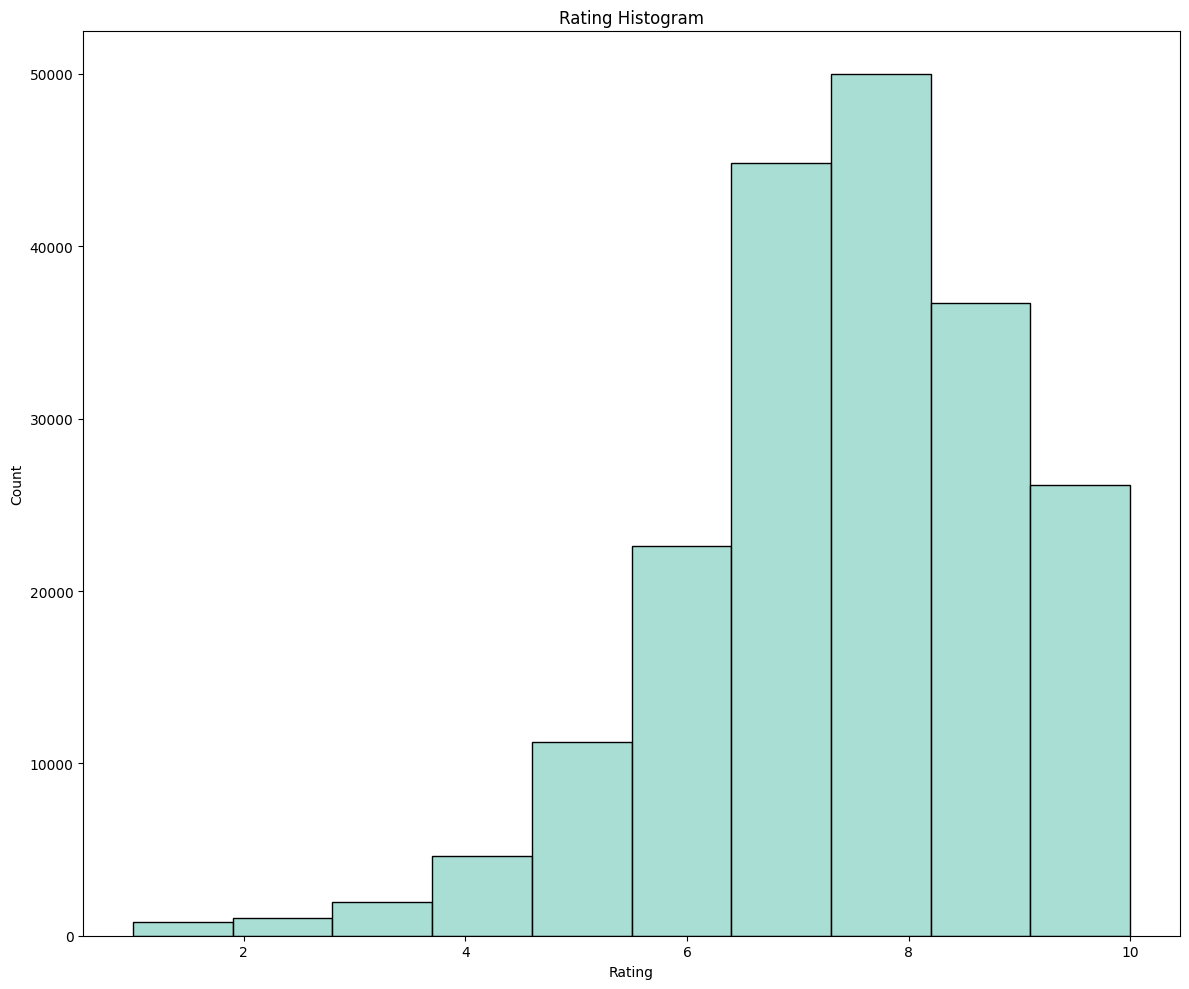

In [24]:
# Histogram user rating
col_box = ['rating']
color_palette = sns.color_palette("Set3", len(col_box))
plt.figure(figsize=(12, 10))

sns.histplot(data=df_user, x='rating', color=color_palette[0], bins = 10)
plt.xlabel('Rating')
plt.title('Rating Histogram')

plt.tight_layout()
plt.savefig('Rating_Histogram.png')
plt.show()

In [25]:
df_user.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 199997 entries, 0 to 199996
Data columns (total 5 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   user_id      199997 non-null  int64 
 1   Username     199997 non-null  object
 2   anime_id     199997 non-null  int64 
 3   Anime Title  199997 non-null  object
 4   rating       199997 non-null  int64 
dtypes: int64(3), object(2)
memory usage: 7.6+ MB


In [26]:
df_anime_cut = df_anime[['anime_id', 'Genres']]
df_anime_cut

,anime_id,Genres
0,1,"Action, Award Winning, Sci-Fi"
1,5,"Action, Sci-Fi"
2,6,"Action, Adventure, Sci-Fi"
3,7,"Action, Drama, Mystery, Supernatural"
4,8,"Adventure, Fantasy, Supernatural"
...,...,...
19971,55729,Avant Garde
19972,55730,Avant Garde
19973,55731,"Comedy, Fantasy, Slice of Life"
19974,55732,"Action, Adventure, Fantasy"


In [27]:
df_user = pd.merge(df_user, df_anime_cut, on='anime_id')
df_user

,user_id,Username,anime_id,Anime Title,rating,Genres
0,91190,-Kei-kun-,6956,Working!!,9,Comedy
1,403440,Skasaha,6956,Working!!,8,Comedy
2,330670,MikolajrAzny,6956,Working!!,10,Comedy
3,392923,durin,6956,Working!!,6,Comedy
4,347704,DarkMvR,6956,Working!!,8,Comedy
...,...,...,...,...,...,...
199992,924969,plamenkai,31139,Ame-iro Cocoa: Rainy Color e Youkoso!,10,"Comedy, Slice of Life"
199993,1246215,MarthKoopa,40610,Healin' Good♡Precure,8,"Action, Fantasy"
199994,323417,ls-la,46431,Yahari Ore no Seishun Love Comedy wa Machigatt...,6,"Comedy, Romance"
199995,372691,Uly,22415,Aoi Heya,10,Fantasy


## Encoding + Build model

In [28]:
user_data = df_user['user_id'].unique().tolist()
user2user_encoded = {x: i for i, x in enumerate(user_data)}
userencoded2user = {i: x for i, x in enumerate(user_data)}

anime_data = df_user['anime_id'].unique().tolist()
anime2anime_encoded = {x: i for i, x in enumerate(anime_data)}
anime_encoded2anime = {i: x for i, x in enumerate(anime_data)}

df_user['user'] = df_user['user_id'].map(user2user_encoded)
df_user['anime'] = df_user['anime_id'].map(anime2anime_encoded)

In [29]:
X = df_user[['user', 'anime']]
y = df_user[['rating']]

scaler = StandardScaler()
y_norm = scaler.fit_transform(y)
y = pd.DataFrame(y_norm, columns = y.columns)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.25, random_state=42, shuffle=True)

In [49]:
class RecommenderNet(tf.keras.Model):

    def __init__(self, num_users, num_anime, embedding_size, **kwargs):
        super(RecommenderNet, self).__init__(**kwargs)
        self.num_users = num_users
        self.num_anime = num_anime
        self.embedding_size = embedding_size
        self.user_embedding = layers.Embedding(
            num_users,
            embedding_size,
            embeddings_initializer='he_normal',
            embeddings_regularizer=regularizers.l2(1e-6)
        )
        self.user_bias = layers.Embedding(num_users, 1)
        self.anime_embedding = layers.Embedding(
            num_anime,
            embedding_size,
            embeddings_initializer='he_normal',
            embeddings_regularizer=regularizers.l2(1e-6)
        )
        self.anime_bias = layers.Embedding(num_anime, 1)
        self.flatten = layers.Flatten()
        self.dense1 = layers.Dense(64, activation='relu')
        self.dense2 = layers.Dense(1, activation='sigmoid')

    def call(self, inputs):
        user_vector = self.user_embedding(inputs[:,0])
        user_bias = self.user_bias(inputs[:, 0])
        anime_vector = self.anime_embedding(inputs[:, 1])
        anime_bias = self.anime_bias(inputs[:, 1])

        dot_user_anime = tf.tensordot(user_vector, anime_vector, 2)

        x = dot_user_anime + user_bias + anime_bias
        x = self.flatten(x)
        x = self.dense1(x)
        x = self.dense2(x)

        return x

In [50]:
# physical_devices = tf.config.list_physical_devices('GPU')
# if len(physical_devices) > 0:
#     device = "/GPU:0"
#     with tf.device(device):
#         model = RecommenderNet(df_user['user_id'].nunique(), df_user['anime_id'].nunique(), 32)
#     print("GPU is used.")
# else:
#     print("GPU is not available. Using CPU instead.")
#     model = RecommenderNet(df_user['user_id'].nunique(), df_user['anime_id'].nunique(), 32)

model = RecommenderNet(df_user['user_id'].nunique(), df_user['anime_id'].nunique(), 48) # inisialisasi model

# model compile
model.compile(
    loss = tf.keras.losses.BinaryCrossentropy(),
    optimizer = keras.optimizers.Adam(),
    metrics=[tf.keras.metrics.RootMeanSquaredError()]
)

In [51]:
model.build((None, 2))
model.summary()

Model: "recommender_net_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_16 (Embedding)    multiple                  4646304   
                                                                 
 embedding_17 (Embedding)    multiple                  96798     
                                                                 
 embedding_18 (Embedding)    multiple                  393024    
                                                                 
 embedding_19 (Embedding)    multiple                  8188      
                                                                 
 flatten_4 (Flatten)         multiple                  0         
                                                                 
 dense_8 (Dense)             multiple                  128       
                                                                 
 dense_9 (Dense)             multiple            

In [52]:
start_lr = 0.00001
min_lr = 0.00001
max_lr = 0.00005
batch_size = 10000

rampup_epochs = 3
sustain_epochs = 0
exp_decay = .8

def lrfn(epoch):
    if epoch < rampup_epochs:
        return (max_lr - start_lr) / rampup_epochs * epoch + start_lr
    elif epoch < rampup_epochs + sustain_epochs:
        return max_lr
    else:
        return (max_lr - min_lr) * exp_decay**(epoch - rampup_epochs - sustain_epochs) + min_lr

lr_callback = LearningRateScheduler(lambda epoch: lrfn(epoch), verbose=0)

checkpoint_filepath = './checkpoint/myanimeweights.h5'

model_checkpoints = ModelCheckpoint(filepath=checkpoint_filepath,
                                    save_weights_only=True,
                                    monitor='val_loss',
                                    mode='min',
                                    save_best_only=True)

early_stopping = EarlyStopping(patience=3, monitor='val_loss', mode='min', restore_best_weights=True)

my_callbacks = [
    model_checkpoints,
    lr_callback,
    early_stopping
]

In [53]:
# Memulai training

history = model.fit(
    x = X_train,
    y = y_train,
    batch_size = 32,
    epochs = 25,
    validation_data = (X_val, y_val),
    callbacks=my_callbacks
)

Epoch 1/25
4688/4688 [==============================] - 33s 7ms/step - loss: 0.6310 - root_mean_squared_error: 1.1029 - val_loss: 0.5606 - val_root_mean_squared_error: 1.0915 - lr: 1.0000e-05
Epoch 2/25
4688/4688 [==============================] - 30s 6ms/step - loss: 0.3916 - root_mean_squared_error: 1.0510 - val_loss: 0.2342 - val_root_mean_squared_error: 1.0249 - lr: 2.3333e-05
Epoch 3/25
4688/4688 [==============================] - 31s 7ms/step - loss: 0.1234 - root_mean_squared_error: 1.0066 - val_loss: 0.0420 - val_root_mean_squared_error: 1.0032 - lr: 3.6667e-05
Epoch 4/25
4688/4688 [==============================] - 30s 6ms/step - loss: -0.0131 - root_mean_squared_error: 0.9981 - val_loss: -0.0725 - val_root_mean_squared_error: 0.9994 - lr: 5.0000e-05
Epoch 5/25
4688/4688 [==============================] - 33s 7ms/step - loss: -0.1664 - root_mean_squared_error: 0.9946 - val_loss: -0.2087 - val_root_mean_squared_error: 0.9942 - lr: 4.2000e-05
Epoch 6/25
4688/4688 [==============

Meskipun nilai *loss* dan *val_loss* bernilai negatif, hal ini tidak menjadi masalah karena `BinaryCrossEntropy()` merupakan interpretasi dari **Negative Log Likelihood**. Hal ini terbukti dari RMSE dan val_RMSE yang masih berusaha mencari titik optimum pada model selama model melakukan proses *training*.

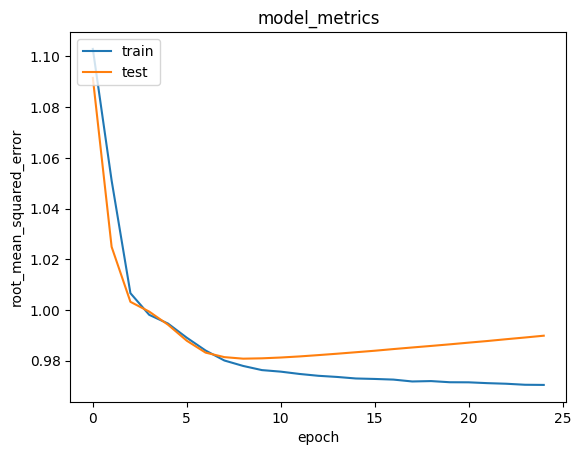

In [54]:
plt.plot(history.history['root_mean_squared_error'])
plt.plot(history.history['val_root_mean_squared_error'])
plt.title('model_metrics')
plt.ylabel('root_mean_squared_error')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## Prediksi Rekomendasi Anime dengan Teknik Collaborative Filtering

In [55]:
user_id = df_user['user_id'].sample(5).iloc[0]
anime_watched = df_user[df_user['user_id'] == user_id]
username_selected = anime_watched[['Username']].iloc[0].values

anime_not_watched = df_user[~df_user['anime_id'].isin(anime_watched['anime_id'].values)]['anime_id']
anime_not_watched = list(
    set(anime_not_watched)
    .intersection(set(anime2anime_encoded.keys()))
)

In [56]:
anime_watched

,user_id,Username,anime_id,Anime Title,rating,Genres,user,anime
10018,375717,Caramelito,1575,Code Geass: Hangyaku no Lelouch,7,"Action, Award Winning, Drama, Sci-Fi",9642,60
32173,375717,Caramelito,5081,Bakemonogatari,4,"Mystery, Romance, Supernatural",9642,216
42545,375717,Caramelito,1482,D.Gray-man,9,"Action, Adventure, Fantasy",9642,321
115590,375717,Caramelito,3731,Itazura na Kiss,9,"Comedy, Romance",9642,1264


In [57]:
anime_not_watched = [[anime2anime_encoded.get(x)] for x in anime_not_watched]

user_encoder = user2user_encoded.get(user_id)

user_anime_array = np.hstack(
    ([[user_encoder]] * len(anime_not_watched), anime_not_watched)
)

In [58]:
# user2user_encoded.get(53322)

In [59]:
# user_encoder

In [60]:
# len(user_anime_array)

In [61]:
ratings = model.predict(user_anime_array).flatten()
top_ratings_indices = ratings.argsort()[-10:][::-1]
recommended_anime_ids = [
    anime_encoded2anime.get(anime_not_watched[x][0]) for x in top_ratings_indices
]

256/256 [==============================] - 1s 2ms/step


In [65]:
print("Rekomendasi untuk user: {}".format(user_id), "AKA {}".format(username_selected))
print("====" * 9)
print("Anime dengan rating tertinggi dari user")
print("----" * 8)
top_movies_user = (
    anime_watched.sort_values(by="rating", ascending=False)
    .head(5)
)
# anime_df_rows = df_user[df_user["anime_id"].isin(top_movies_user)]
# count = 0
for _, row in top_movies_user.iterrows():
    print(f"{row['Anime Title']} ==>\t{row['Genres']}")

print("----" * 8)
print("Top 10 rekomendasi anime")
print("----" * 8)
recommended_movies = df_user[df_user["anime_id"].isin(recommended_anime_ids)]

count = 0
displayed_titles = set()
for _, row in recommended_movies.iterrows():
    if row['Anime Title'] not in displayed_titles:
        print(row['Anime Title'], "\t ==>\t", row['Genres'])
        displayed_titles.add(row['Anime Title'])
        count += 1
    if count == 10:
        break

Rekomendasi untuk user: 375717 AKA ['Caramelito']
Anime dengan rating tertinggi dari user
--------------------------------
Itazura na Kiss ==>	Comedy, Romance
D.Gray-man ==>	Action, Adventure, Fantasy
Code Geass: Hangyaku no Lelouch ==>	Action, Award Winning, Drama, Sci-Fi
Bakemonogatari ==>	Mystery, Romance, Supernatural
--------------------------------
Top 10 rekomendasi anime
--------------------------------
Gintama' 	 ==>	 Action, Comedy, Sci-Fi
Hunter x Hunter (2011) 	 ==>	 Action, Adventure, Fantasy
Cowboy Bebop 	 ==>	 Action, Award Winning, Sci-Fi
Clannad: After Story 	 ==>	 Drama, Romance, Supernatural
Code Geass: Hangyaku no Lelouch R2 	 ==>	 Action, Award Winning, Drama, Sci-Fi
Fullmetal Alchemist: Brotherhood 	 ==>	 Action, Adventure, Drama, Fantasy
Steins;Gate 	 ==>	 Drama, Sci-Fi, Suspense
Howl no Ugoku Shiro 	 ==>	 Adventure, Award Winning, Drama, Fantasy, Romance
Great Teacher Onizuka 	 ==>	 Comedy
Rurouni Kenshin: Meiji Kenkaku Romantan - Tsuioku-hen 	 ==>	 Action, Dram

Dari *anime* yang pernah ditonton oleh *user* terpilih, model dapat memprediksi 10 *anime* yang cocok untuk *user*. Hasil rekomendasi yang disarankan memiliki **akurasi yang sangat baik**. Hal ini terbukti dari genre *anime* yang pernah ditonton oleh *user* sesuai dengan genre *anime* yang disarankan oleh model.

# Sekian Terima Kasih

### Created by: Andika Rahman Teja